In [ ]:
import os

print(len(os.listdir("/content/drive/MyDrive/QRCODE_model/dataset/original")))

4986


In [ ]:
print(len(os.listdir("/content/drive/MyDrive/QRCODE_model/dataset/lr_imgs")))

4986


In [ ]:
print(len(os.listdir("/content/drive/MyDrive/QRCODE_model/dataset/hr_imgs")))

4986


Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


Defining Block to Generator

In [ ]:
def block_res(ip):

  res_model = Conv2D(64, (3, 3), padding = "same")(ip)
  res_model = BatchNormalization(momentum = 0.5)(res_model)
  res_model = PReLU(shared_axes = [1,2])(res_model)

  res_model = Conv2D(64, (3, 3), padding = "same")(res_model)
  res_model = BatchNormalization(momentum = 0.5)(res_model)
  return add([ip, res_model])

def block_upscale(ip):

  up_model = Conv2D(256, (3, 3), padding = "same")(ip)
  up_model = UpSampling2D(size = 2)(up_model)
  up_model = PReLU(shared_axes = [1,2])(up_model)
  return up_model

Create Generator function

In [ ]:
def create_generator(gen_ip, num_res_block):

  layers = Conv2D(64, (9, 9), padding = "same")(gen_ip)
  layers = PReLU(shared_axes = [1,2])(layers)

  temp = layers

  for index in range(num_res_block):
    layers = block_res(layers)

  layers = Conv2D(64, (3, 3), padding = "same")(layers)
  layers = BatchNormalization(momentum = 0.5)(layers)
  layers = add([layers, temp])

  layers = block_upscale(layers)
  layers = block_upscale(layers)

  op = Conv2D(3, (9, 9), padding = "same")(layers)

  return Model(inputs=gen_ip, outputs=op)




Defining Block to Discriminator

In [ ]:
def block_discriminator(ip, filters, strides=1, bn=True):

  disc_model = Conv2D(filters, (3, 3), strides = strides, padding = "same")(ip)

  if bn:
    disc_model = BatchNormalization(momentum = 0.8)(disc_model)

  disc_model = LeakyReLU(alpha = 0.2)(disc_model)

  return disc_model

Create Discrimination Function

In [ ]:
def create_discriminator(disc_ip):

  df = 64

  d1 = block_discriminator(disc_ip, df, bn = False)
  d2 = block_discriminator(d1, df, strides = 2)
  d3 = block_discriminator(d2, df*2)
  d4 = block_discriminator(d3, df*2, strides = 2)
  d5 = block_discriminator(d4, df*4)
  d6 = block_discriminator(d5, df*4, strides = 2)
  d7 = block_discriminator(d6, df*8)
  d8 = block_discriminator(d7, df*8, strides = 2)

  d8_5 = Flatten()(d8)
  d9 = Dense(df*16)(d8_5)
  d10 = LeakyReLU(alpha = 0.2)(d9)
  validity = Dense(1, activation = "sigmoid")(d10)

  return Model(disc_ip, validity)

In [ ]:
from keras.applications.vgg19 import VGG19

def vgg_build(hr_shape):

  vgg = VGG19(weights = "imagenet", include_top = False, input_shape = hr_shape)

  return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
def create_combined(gen_model, disc_model, vgg, lr_ip, hr_ip):
  gen_img = gen_model(lr_ip)

  gen_features = vgg(gen_img)

  disc_model.trainable = False
  validity = disc_model(gen_img)
  return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

Setting fixed of training dataset

In [ ]:
n = 1500
lr_list = os.listdir("/content/drive/MyDrive/QRCODE_model/dataset/lr_imgs")[:n]

lr_images = []
for images in lr_list:
  images_lr = cv2.imread("/content/drive/MyDrive/QRCODE_model/dataset/lr_imgs/" + images)
  images_lr = cv2.cvtColor(images_lr, cv2.COLOR_BGR2RGB)
  lr_images.append(images_lr)

hr_list = os.listdir("/content/drive/MyDrive/QRCODE_model/dataset/hr_imgs")[:n]

hr_images = []
for images in hr_list:
  images_hr = cv2.imread("/content/drive/MyDrive/QRCODE_model/dataset/hr_imgs/" + images)
  images_hr = cv2.cvtColor(images_hr, cv2.COLOR_BGR2RGB)
  hr_images.append(images_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

Visualization of Image

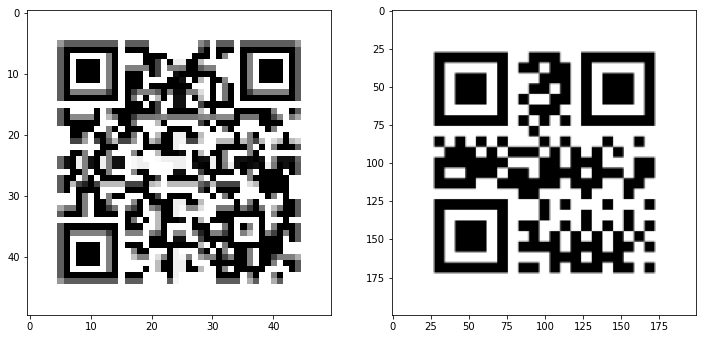

In [ ]:
import random
import numpy as np

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (50, 50, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (200, 200, 3)))
plt.show()


In [ ]:
# Scaling values

lr_images = lr_images / 255.
hr_images = hr_images / 255.

# Split into train and test

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                        test_size=0.33, random_state=42)

Generate VGG Model

In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_generator(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = vgg_build((200, 200, 3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_combined(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 50, 50, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 50, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-4, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 200, 200, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            93299521    ['model[0][0]']            

Creating Batch Size

In [ ]:
batch_size = 1
train_lr_batch = []
train_hr_batch = []
for a in range(int(hr_train.shape[0] / batch_size)):
  start_id = a * batch_size
  end_id = start_id + batch_size
  train_hr_batch.append(hr_train[start_id:end_id])
  train_lr_batch.append(lr_train[start_id:end_id])


Training Dataset

In [ ]:
epochs = 5
for e in range(epochs):

  fake_label = np.zeros((batch_size, 1))
  real_label = np.ones((batch_size, 1))

  gen_loss = []
  disc_loss = []

  for a in tqdm(range(len(train_hr_batch))):
    lr_img = train_lr_batch[a]
    hr_img = train_hr_batch[a]

    fake_img = generator.predict_on_batch(lr_img)

    discriminator.trainable = True
    d_loss_gen = discriminator.train_on_batch(fake_img, fake_label)
    d_loss_real = discriminator.train_on_batch(hr_img, real_label)

    discriminator.trainable = False

    d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

    image_features = vgg.predict(hr_img)

    g_loss, _, _ = gan_model.train_on_batch([lr_img, hr_img], [real_label, image_features])

    #Save losses to a list so we can average and report. 
    disc_loss.append(d_loss)
    gen_loss.append(g_loss)

  #Convert the list of losses to an array to make it easy to average    
  gen_loss = np.array(gen_loss )
  disc_loss = np.array(disc_loss)
    
  #Calculate the average losses for generator and discriminator
  g_loss = np.sum(gen_loss, axis=0) / len(gen_loss)
  d_loss = np.sum(disc_loss, axis=0) / len(disc_loss)
    
  #Report the progress during training. 
  print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
      #Save the generator after every n epochs (Usually 10 epochs)
      generator.save("gen_e_"+ str(e+1) +".h5")

100%|██████████| 1005/1005 [04:15<00:00,  3.94it/s]


epoch: 1 g_loss: 153.6031085341724 d_loss: [1.70579664 0.98756219]


100%|██████████| 1005/1005 [03:58<00:00,  4.21it/s]


epoch: 2 g_loss: 130.10758276033164 d_loss: [0. 1.]


100%|██████████| 1005/1005 [03:56<00:00,  4.24it/s]


epoch: 3 g_loss: 127.12057646945934 d_loss: [0. 1.]


100%|██████████| 1005/1005 [03:56<00:00,  4.24it/s]


epoch: 4 g_loss: 124.59626227231762 d_loss: [0. 1.]


100%|██████████| 1005/1005 [03:57<00:00,  4.24it/s]

epoch: 5 g_loss: 123.6850916696425 d_loss: [0.97075736 0.99751244]


In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_5.h5', compile=False)

In [ ]:
from keras.models import load_model
import tensorflow as tf

model = tf.keras.models.load_model('gen_e_5.h5', compile=False)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9fu8ufgl/assets


8173236

Visualization of Image using the model

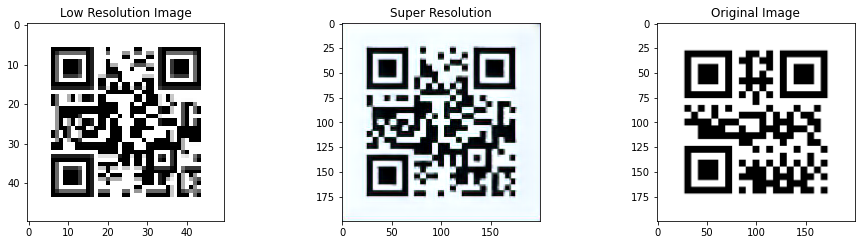

In [ ]:
[x1, x2] = [lr_test, hr_test]
ex = randint(0, len(x1), 1)   #selesct random example
src_img, target_img = x1[ex], x2[ex]

gen_image = generator.predict(src_img)

#plot images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution Image')
plt.imshow(src_img[0,:,:])
plt.subplot(232)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Original Image')
plt.imshow(target_img[0,:,:,:])
plt.show()


In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/sample_data/gen_e_5.h5', compile=False)
